In [1]:
from sympy import *
# https://docs.sympy.org/latest/tutorials/intro-tutorial/printing.html

# https://stackoverflow.com/questions/40806591/how-do-i-display-a-full-expression-in-sympy
from IPython.display import display, Math

U, V, omega, t, x, y, r_0, q, m, v_v, v_p = symbols('U V omega t x y r_0 q m v_v v_p')
init_printing()

v_ex = Matrix([1,0,0]) 
v_ey = Matrix([0,1,0])
v_ez = Matrix([0,0,1])

# theory prerequisite

# RF + DC offset of the quadrupole
phi_0 = U + V * cos(omega * t)

# potential inside a quadrupole at a given point in space
phi  = phi_0 * (x**2 - y**2) / (2 * r_0**2)

# In the first step the electric field is derived from the potiential distribution
# with the formula E = -\nabla * phi.

# calculating the partial derivateives for the nabla operation(gradient)
dx = diff(phi, x)
dy = diff(phi, y)

v_E =  -(dx * v_ex + dy* v_ey)

display(Math(latex('\overrightarrow{E} = ') + latex(v_E)))

# in the seccond step the lorenz force is determined with the formulafor considering B = 0!
# F = E * q

v_F = v_E * q

display(Math('\overrightarrow{F} = '+latex(v_F)))

# With the force the acceleration can be determined with respect to the ions mass
# a = F / m

v_a = v_F / m

display(Math('\overrightarrow{a} = '+latex(v_a)))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

class Ion:
    def __init__(self,position, charge, mass, v_z):
        self.position = position
        self.charge = charge
        self.m = mass
        self.v_z = v_z
        self.F = np.array([[0],[0],[0]])

class infiniteLengthQuadrupole:
    def __init__(self,R,r_0):
        # rod radius
        self.R = R
        # rod placement radius
        self.r_0 = r_0
        # rod positions
        self.pPole = np.array([[[ (R + r_0)/np.sqrt(2)],
                                [(R + r_0)/np.sqrt(2)],
                                [0]],
                                [[-(R + r_0)/np.sqrt(2)],
                                 [(R + r_0)/np.sqrt(2)],
                                 [0]],
                                [[-(R + r_0)/np.sqrt(2)],
                                 [-(R + r_0)/np.sqrt(2)],
                                 [0]],
                                [[(R + r_0)/np.sqrt(2)],
                                 [-(R + r_0)/np.sqrt(2)],
                                 [0]]])
        # rod pseudo charges
        self.rodsPseudoQ = np.zeros(4)
        # K factor for simplification ofcalculating the equations
        self.K = 1 / (4 * np.pi * sc.epsilon_0)
        
        self.forces= []
        
    def check(self):
        print('pole positions')
        print(self.pPole)
        print('pseudo charges')
        print(self.rodsPseudoQ)
        
    def phi_0(self,U, V, f, t):
        return U + V * np.sin(2 * np.pi * f * t)
    
    def coulombForceOnQ1(self,Q1,Q2,r1,r2):
        a = self.K * Q1 * Q2
        r12 = r1 - r2
        mag_r12 = np.linalg.norm(r12)
        # calculate force
        return a * r12 / (mag_r12**3)
    
    def getUV(self, mass_amu, f, a, q):
        U = a * 1.66054e-27 * mass_amu * (2 * np.pi * f)**2 *self.r_0**2 /  (8 * sc.e)
        V = q * 1.66054e-27 * mass_amu * (2 * np.pi * f)**2 *self.r_0**2 /  (4 * sc.e)
        return U, V
        
    
    def calcNewIonPos_1(self,U,V,f,ion,t_s,t):
        # check if ion has left the r_0 boundary
        if np.linalg.norm(ion.position) >= self.r_0:
            return None
        
        phi_0 = U + V * np.sin(2 * np.pi * f * t)
        a_x = -(float(ion.position[0]) * phi_0) / (self.r_0**2) * ion.charge / ion.m
        a_y = (float(ion.position[1]) * phi_0) / (self.r_0**2) * ion.charge / ion.m
                
        newPosition = 0.5 * t_s**2 * np.array([[a_x],[a_y],[0]])
        newPosition[2] = float(ion.position[2])
        
        # velocity component in z
        newPosition[2] =  newPosition[2] + ion.v_z * t_s
        
        # ion position update
        ion.position = newPosition

        #print(newPosition)
        
        return newPosition
        
    def calcNewIonPos(self,U,V,f,ion,t_s,t):
        
        # check if ion has left the r_0 boundary
        if np.linalg.norm(ion.position) >= self.r_0:
            return None
        
        signLUT = [1,-1,1,-1]
        index = 0;
        
        # reset force
        F_c = np.array([[0],[0],[0]])
        
        for Q in self.rodsPseudoQ:

            
            # calculate the pseudo charge points of the quadrupole
            Q = signLUT[index] * self.phi_0(U,V,f,t)/2 * self.K * self.R
            
            # match pseudo charge with ion in z direction
            self.pPole[index][2] = ion.position[2]
            
            #print('ion position', ion.position)
            #print(self.pPole[index])
            
            # calculate force on ion
            F_q = self.coulombForceOnQ1(ion.charge,
                                        Q,
                                        self.pPole[index],
                                        ion.position)
            #print(F_q)
            
            F_c = F_c + F_q
            self.forces.append(F_c)
            
            # update index
            index = index + 1
            
        ion.F = F_c
        # http://lampx.tugraz.at/~hadley/physikm/problems/rvaF/index.en.php
        newPosition = 0.5 * t_s**2 * 1 / ion.m * ion.F + ion.position
        
        # velocity component in z
        newPosition[2] =  newPosition[2] + ion.v_z * t_s

        #print(newPosition)
        
        return newPosition
    
N_periodes = 100000
N_points_per_period = 11
f = 1.1e6    
t_step = 1 / f / N_points_per_period
t_sim = 0
N = N_periodes * N_points_per_period

# coffein atom 524.50002164 dalton (8.709527e-25 kg)


#ion = Ion(np.array([[1e-10],[1e-10],[0]]), sc.e, 1.661e-27,100)
ion = Ion(np.array([[1e-10],[1e-10],[0]]), sc.e, 1220 * 1.66054e-27,100)

# quadrupole
quad = infiniteLengthQuadrupole(0.0101, 0.01)

#quad.check()

positions = []

p_x = []
p_y = []
p_z = []

print(quad.getUV(1220,f,0.1,0.7))


positions.append(ion.position)
print('N =',N)
for n in range(0,N-1,1):
    
    newPos = quad.calcNewIonPos_1(755.0120770093375, 10570.169078130726,f,ion,t_step,t_sim)
    #newPos = quad.calcNewIonPos_1(100,100,f,ion,t_step,t_sim)
    
    if(newPos is None):
        print('ion has left the boundary!')
        break
        
    
    ion.position = newPos
    
    if n % 100 is 0 and 0:
        print(newPos)
        #positions.append(newPos)
    
    if 0:
        positions.append(newPos)
    
    if 1:
        p_x.append(float(newPos[0]))
        p_y.append(float(newPos[1]))
        p_z.append(float(newPos[2]))
        
    
    t_sim += t_step

print('n =',n)
print('simulation time = ', t_sim)
print('number of positiions = ', len(positions))

if 1:
    print(p_x[:10])


if 0:
    print(positions[:10])



print('done!')

(755.0120770093375, 10570.169078130726)
N = 1100000
ion has left the boundary!
n = 1210
simulation time =  9.999999999999773e-05
number of positiions =  1
[-2.0391744630349912e-13, 3.56317754718436e-15, -9.979659008986673e-17, 3.0235407792913644e-18, -7.139985036292582e-20, 7.19867582572237e-22, 4.321977872069379e-24, 8.443545107936075e-26, 2.2137865823636512e-27, 5.297458959531464e-29]
done!


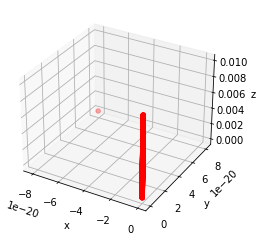

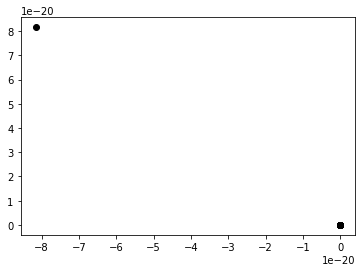

In [112]:
if 0:
    n_start = 500
    n_end = 3000
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(p_x[n_start:n_end],p_y[n_start:n_end],p_z[n_start:n_end],c = 'r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

if 1:

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(p_x,p_y,p_z,c = 'r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    
if 1:
    plt.plot(p_x, p_y, 'o', color='black');


In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#print(positions[1:2](0))
print(np.array(positions.shape))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:][0], positions[:][1], positions[:][2], zdir='z', c= 'red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.savefig("demo.png")

AttributeError: 'list' object has no attribute 'shape'